#PointNet Classification


## **Pointnet é uma rede neural profunda que consome diretamente a nuvem de pontos 3D e fornece uma abordagem unificada para tarefas como classificação e segmentação.**

<center>
    <img src="https://stanford.edu/~rqi/pointnet/images/teaser.jpg" alt="centered image" />
</center>



# **1. Install dependency**

In [3]:
#pip install -r requirements.txt  

# **2. Import necessary library**

In [ ]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# Configuração de semente para reprodutibilidade
tf.random.set_seed(1234)

In [ ]:
import sys
import os

# Caminho para a raiz do projeto (sobe dois níveis a partir do notebook)
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if project_root not in sys.path:
    sys.path.append(project_root)


# **3. Download the pointcloud data**

In [ ]:
from utils import download_modelnet

DATA_DIR = download_modelnet.download()
print(f"Dataset disponível em: {DATA_DIR}")


Baixando http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip para c:\Users\duart\Documents\GitHub\computer-graphics\data\ModelNet10.zip...
Extraindo c:\Users\duart\Documents\GitHub\computer-graphics\data\ModelNet10.zip para c:\Users\duart\Documents\GitHub\computer-graphics\data...
Dataset ModelNet10 extraído para: c:\Users\duart\Documents\GitHub\computer-graphics\data\ModelNet10
Dataset disponível em: c:\Users\duart\Documents\GitHub\computer-graphics\data\ModelNet10


# **4. Visualize the pointcloud data**

Mesh carregada: <trimesh.Trimesh(vertices.shape=(64, 3), faces.shape=(96, 3))>


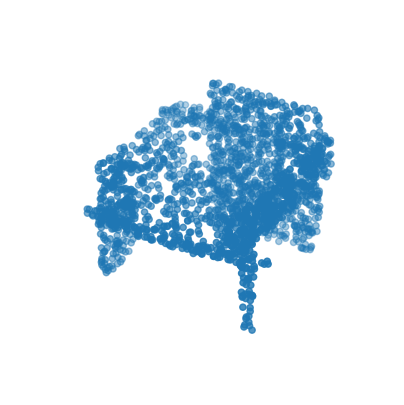

In [ ]:
try:
    mesh_path = os.path.join(DATA_DIR, "chair/train/chair_0002.off")
    if os.path.exists(mesh_path):
        mesh = trimesh.load(mesh_path)
        print(f"Mesh carregada: {mesh}")
        # mesh.show()  # Isso pode abrir uma janela separada
        
        # Amostra pontos da malha 3D
        points = mesh.sample(2048)
        
        # Visualiza os pontos em um gráfico 3D
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111, projection="3d")
        ax.scatter(points[:, 0], points[:, 1], points[:, 2])
        ax.set_axis_off()
        plt.show()
    else:
        print(f"Arquivo não encontrado: {mesh_path}")
        # Lista os diretórios disponíveis para ajudar a depurar
        print(f"Conteúdo de DATA_DIR: {os.listdir(DATA_DIR)}")
        
        # Tenta encontrar a pasta de cadeiras
        chair_paths = glob.glob(os.path.join(DATA_DIR, "*chair*"))
        print(f"Possíveis caminhos para cadeiras: {chair_paths}")
except Exception as e:
    print(f"Erro ao carregar ou visualizar o modelo: {e}")

# **5. Data preprocessing and augmentation**

In [ ]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [ ]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

processing class: bathtub
processing class: bed
processing class: chair
processing class: night_stand
processing class: sofa
processing class: table
processing class: toilet


In [ ]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

In [ ]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [ ]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

# **6. Building the model**

<img src="https://www.researchgate.net/publication/343806184/figure/fig2/AS:930138283835393@1598773656168/PointNet-10-and-PointNet-12-architectures.jpg" alt="centered image" />

In [ ]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [ ]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

NameError: name 'keras' is not defined

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=15, validation_data=test_dataset)

NameError: name 'model' is not defined

# **7. Test data and Visualize**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


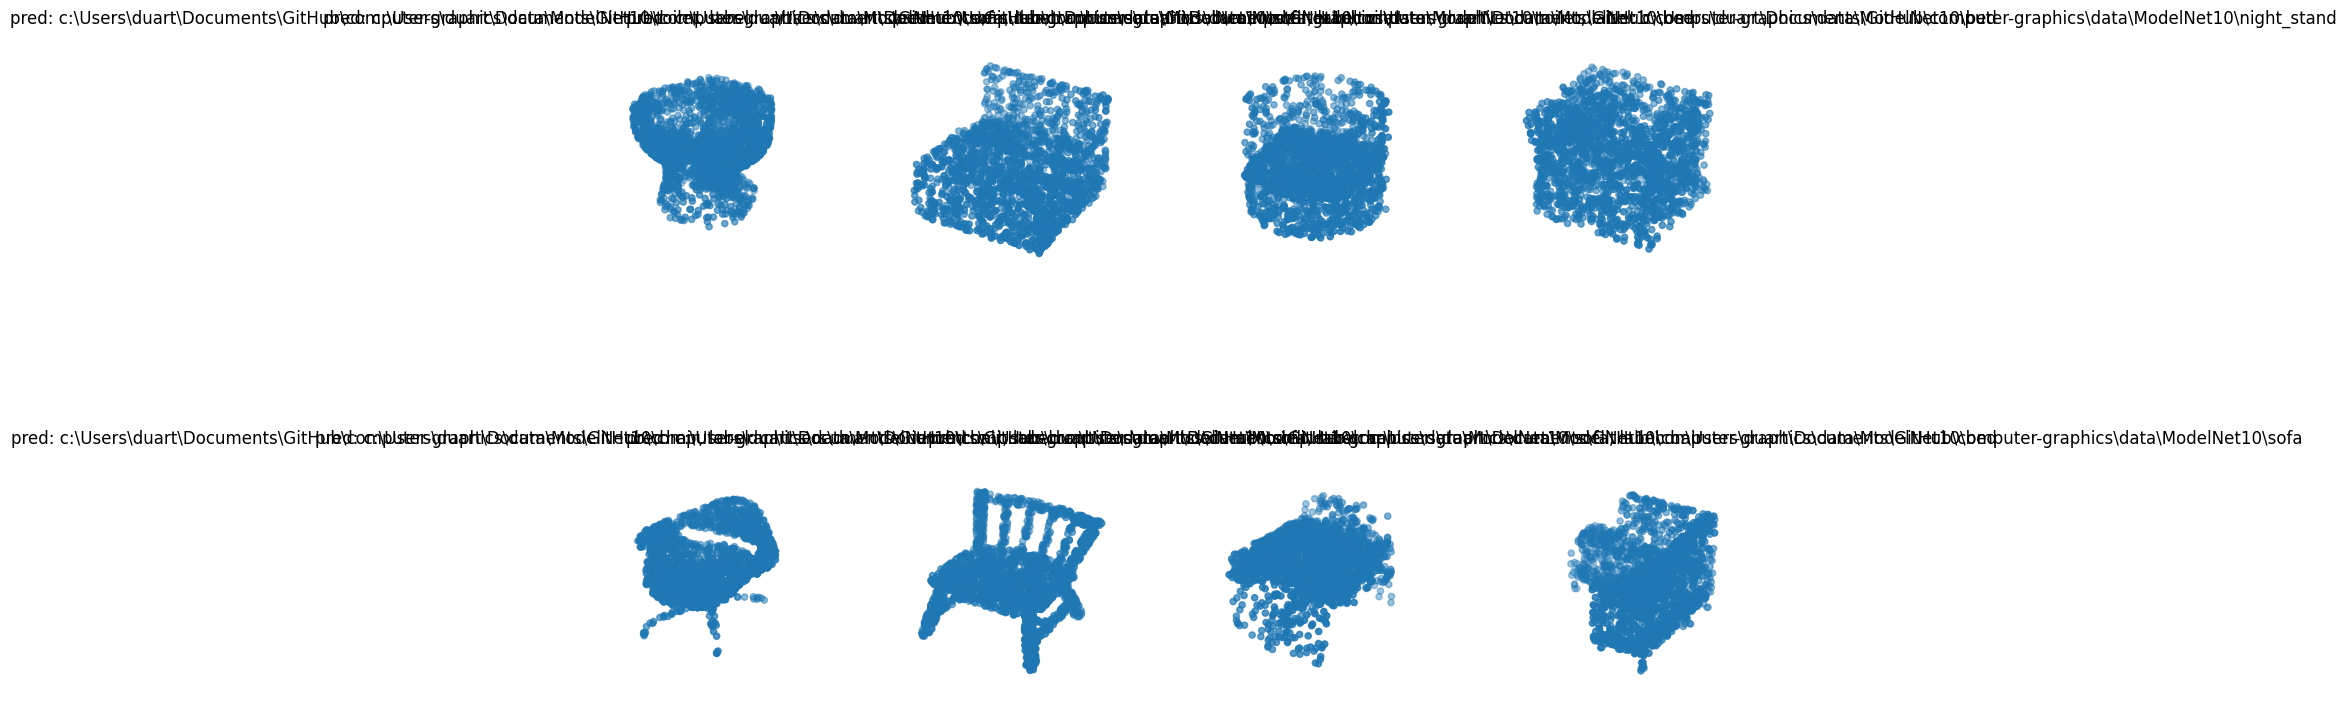

In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

# Teste em uma imagem fora do dataset

In [ ]:
import os

# Usa __file__ se possível, ou então cwd (para notebooks)
project_root = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()

# Arquivo .obj está na mesma pasta do notebook
custom_model_path = os.path.join(project_root, "Wood_Table.obj")

# Verificações
print(f"Diretório atual (raiz do projeto): {project_root}")
print(f"Caminho completo do modelo: {custom_model_path}")

file_exists = os.path.exists(custom_model_path)
print(f"O arquivo existe? {file_exists}")


Diretório atual (raiz do projeto): c:\Users\duart\Documents\GitHub\computer-graphics\point_cloud\projeto_01
Caminho completo do modelo: c:\Users\duart\Documents\GitHub\computer-graphics\point_cloud\projeto_01\Wood_Table.obj
O arquivo existe? True


In [ ]:
mesh2 = trimesh.load(custom_model_path)

mesh2.show()

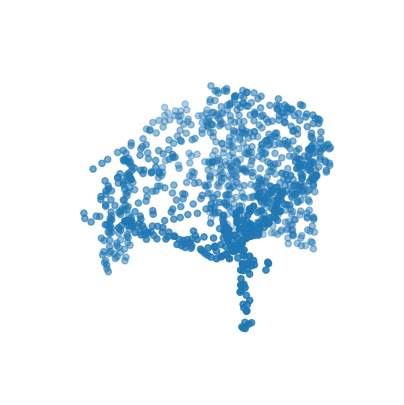

In [ ]:
# Verifica se veio como Scene
if isinstance(mesh, trimesh.Scene):
    # Junta todos os geometries em uma só malha (flatten)
    mesh = trimesh.util.concatenate(
        [g for g in mesh.geometry.values()]
    )

# Agora mesh é do tipo Trimesh
points = mesh.sample(1000)

# Visualiza (opcional)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [ ]:
points -= points.mean(axis=0)
points /= np.max(np.linalg.norm(points, axis=1))

# Converte para tensor e adiciona batch
points_tf = tf.convert_to_tensor(points[None, ...], dtype=tf.float32)

# Predição
pred = model.predict(points_tf)
pred_label = tf.argmax(pred, axis=-1).numpy()[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


In [ ]:
# Resultado
print("Classe prevista:", CLASS_MAP[pred_label])

Classe prevista: c:\Users\duart\Documents\GitHub\computer-graphics\data\ModelNet10\toilet


In [ ]:
# 4. Visualiza a nuvem de pontos
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='skyblue', s=1)
ax.set_title(f"Resultado da Classificação: Classe {pred_class}")
plt.show()